<a href="https://githubtocolab.com/geonextgis/cropengine/blob/main/docs/examples/Run parameter optimization (wofost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Uncomment the following line to install the latest version of [cropengine](https://geonextgis.github.io/cropengine) if needed.

In [ ]:
# !pip install -U cropengine

## Import libraries

In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cropengine import WOFOSTCropSimulationBatchRunner
from cropengine.agromanagement import WOFOSTAgroEventBuilder
from cropengine.optimizer import WOFOSTOptimizer

from sklearn.metrics import mean_squared_error

## Instantiate batch crop simulation engine for WOFOST

In [3]:
# Define the model name
MODEL_NAME = "Wofost72_WLP_CWB"

# Define the csv path with 'id', 'latitude', and 'longitude'
locations_csv_path = 'test_data/optimizer/location.csv'

# Initialize Engine
batch_runner = WOFOSTCropSimulationBatchRunner(model_name=MODEL_NAME, locations_csv_path=locations_csv_path, workspace_dir='test_output/optimizer_workspace')

## User inputs

In [4]:
# Crop Configuration
models = batch_runner.get_model_options()

crops = batch_runner.get_crop_options(MODEL_NAME)
CROP_NAME = "wheat"
varieties = batch_runner.get_variety_options(MODEL_NAME, CROP_NAME)
CROP_VARIETY = "Winter_wheat_103"

# Timing
crop_start_end = batch_runner.get_crop_start_end_options()
CAMPAIGN_START = "2019-09-01"
CROP_START = "2019-09-25"
CROP_START_TYPE = "sowing"
CROP_END_TYPE = "maturity"
CROP_END = None
CAMPAIGN_END = "2020-09-30"
MAX_DURATION = 365

## Create agromanagements with user inputs

In [5]:
agro_event_builder = WOFOSTAgroEventBuilder()

# Note: Use agro_event_builder.get_..._events_info() to see valid values if unsure
timed_events_info = agro_event_builder.get_timed_events_info()
state_events_info = agro_event_builder.get_state_events_info()

# Build timed events (irrigation)
irrigation_schedule = [
    {"event_date": "2020-03-20", "amount": 3.0, "efficiency": 0.7},  # stem elongation
    {"event_date": "2020-04-25", "amount": 2.5, "efficiency": 0.7},  # booting/heading
    {"event_date": "2020-05-20", "amount": 2.0, "efficiency": 0.7},  # flowering
]

irrigation_events = agro_event_builder.create_timed_events(
    signal_type="irrigate", events_list=irrigation_schedule
)

# Build state Events (fertilization based on DVS)
nitrogen_schedule = [
    {"threshold": 0.3, "N_amount": 40, "N_recovery": 0.7},   # early vegetative
    {"threshold": 0.6, "N_amount": 60, "N_recovery": 0.7},   # stem elongation
    {"threshold": 1.0, "N_amount": 40, "N_recovery": 0.7},   # heading
]

nitrogen_events = agro_event_builder.create_state_events(
    signal_type="apply_n",
    state_var="DVS",
    zero_condition="rising",
    events_list=nitrogen_schedule,
)

## Prepare batch system

In [6]:
batch_runner.prepare_batch_system(
    campaign_start=CAMPAIGN_START,
    campaign_end=CAMPAIGN_END,
    crop_start=CROP_START,
    crop_start_type=CROP_START_TYPE,
    crop_end_type=CROP_END_TYPE,
    crop_end=CROP_END,
    max_duration=MAX_DURATION,
    crop_name=CROP_NAME,
    variety_name=CROP_VARIETY,
    timed_events=[irrigation_events],
    state_events=[nitrogen_events],
    force_update=False,
    WAV=10  # Extra site params can be passed as a kwargs
)

[BATCH PREP] Preparing tasks for 5 locations...
[BATCH PREP] Starting preparation with 4 workers...


Preparing Data:   0%|          | 0/5 [00:00<?, ?it/s]

Preparing Data: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

[BATCH PREP] Completed. 5/5 locations ready.


## Run the simulation first

In [7]:
results = batch_runner.run_batch_simulation(max_workers=5)
print(results.shape)
results.head()

[BATCH RUN] Preparing execution tasks for 5 locations...
[BATCH RUN] Starting simulation with 5 workers...


Simulating: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


[BATCH RUN] Success! Results saved to c:\HALDER\GITHUB\LEARNING\cropengine\docs\examples\test_output\optimizer_workspace\batch_results.csv
(1980, 16)


,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,RFTRA,point_id,latitude,longitude
0,2019-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,22.000000,NaN,1,50.394005,12.100607
1,2019-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345490,22.327083,NaN,1,50.394005,12.100607
2,2019-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.301330,22.035979,NaN,1,50.394005,12.100607
3,2019-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292283,21.945514,NaN,1,50.394005,12.100607
4,2019-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.284434,21.867024,NaN,1,50.394005,12.100607


## Plot the results (before optimization)

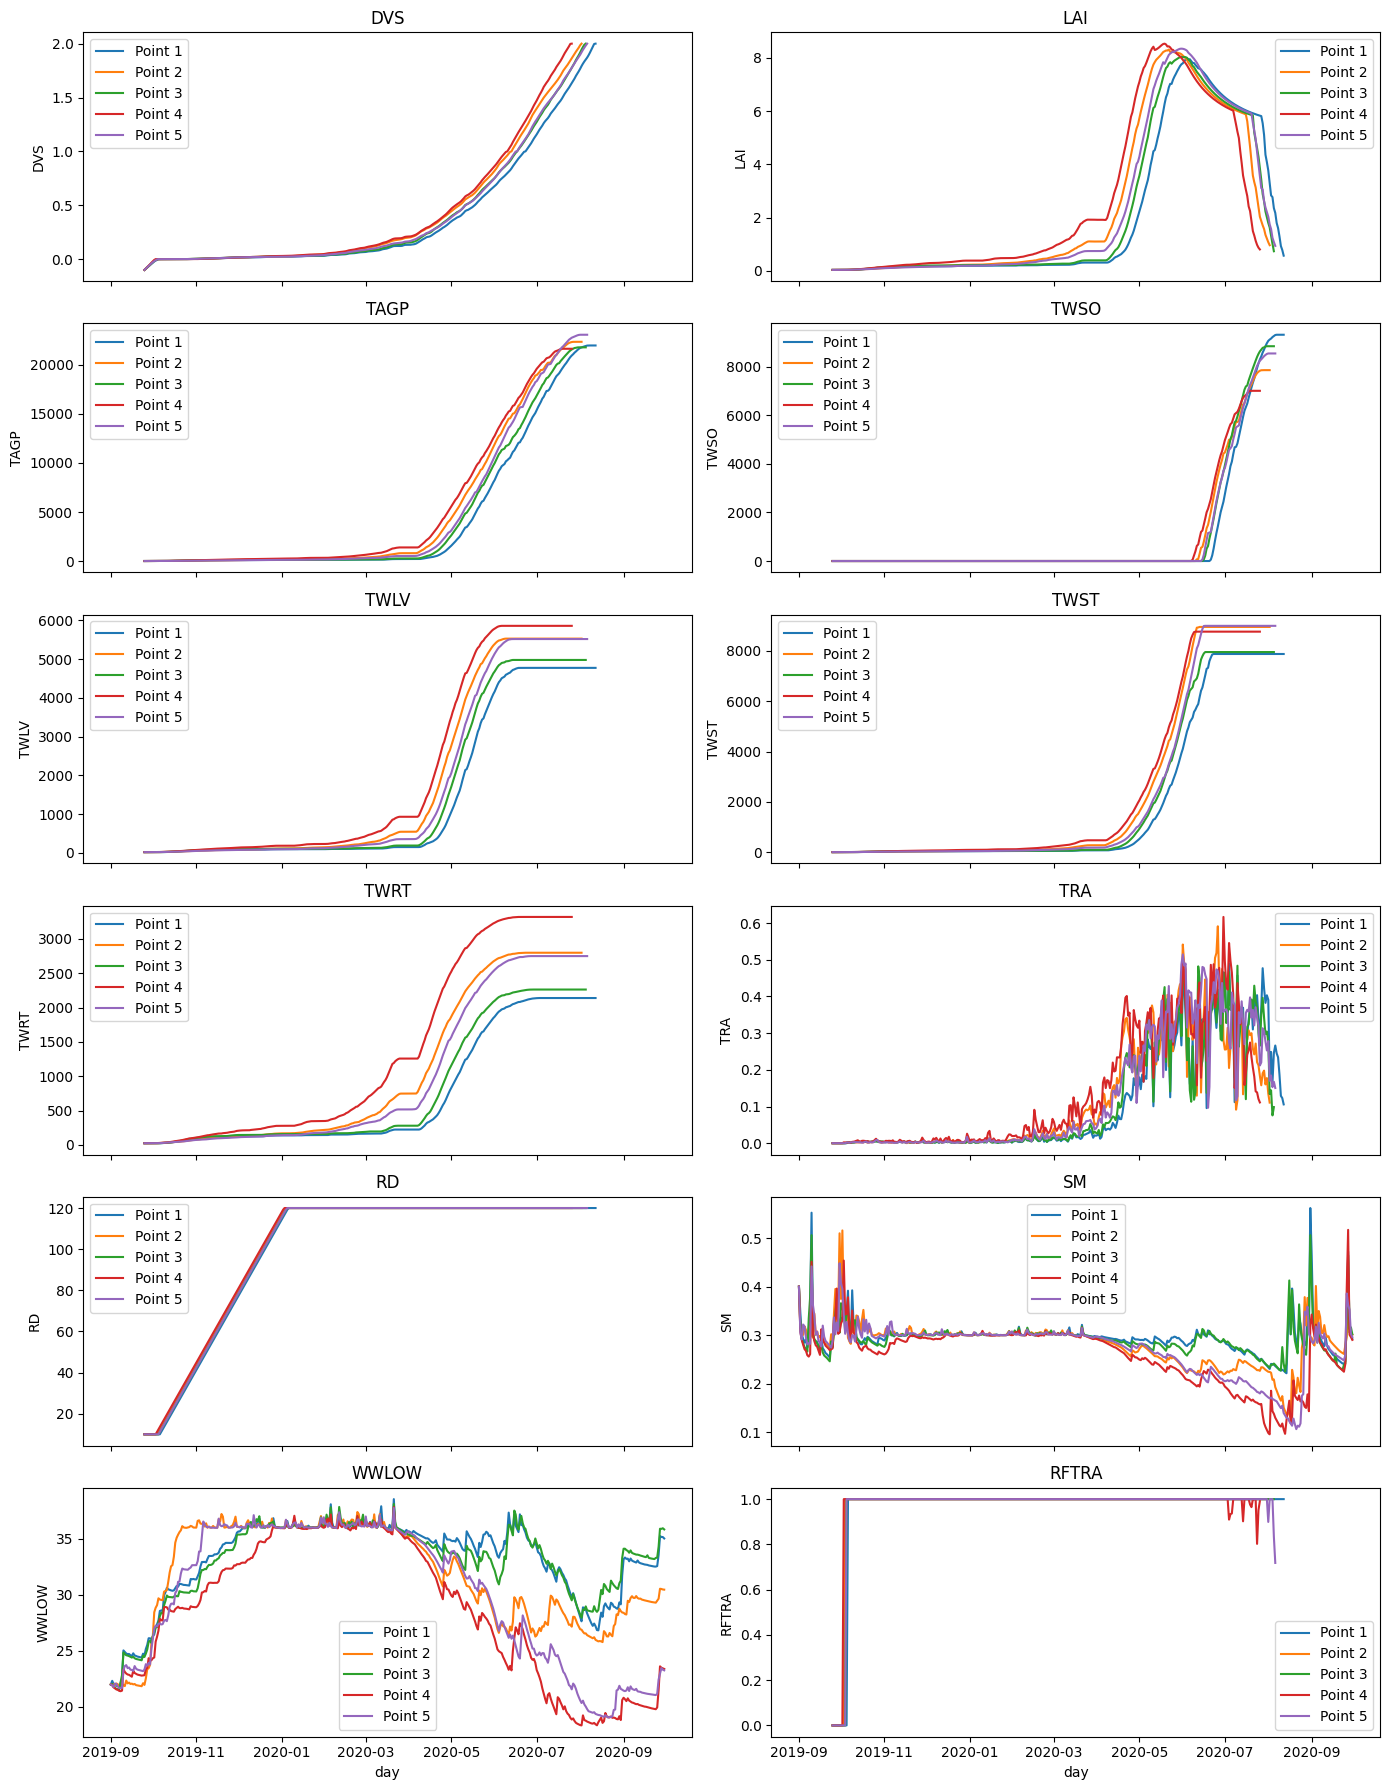

In [8]:
# Ensure 'day' is datetime
batch_results = results.copy()
batch_results['day'] = pd.to_datetime(batch_results['day'])

# Variables to plot (exclude metadata columns)
vars_to_plot = [
    col for col in batch_results.columns 
    if col not in ['point_id', 'latitude', 'longitude', 'day']
]

# Layout
cols = 2
rows = math.ceil(len(vars_to_plot) / cols)

# Colors for point_id groups
unique_points = batch_results['point_id'].unique()
palette = sns.color_palette("tab10", len(unique_points))
color_map = {pid: palette[i] for i, pid in enumerate(unique_points)}

fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows), sharex=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    for pid in unique_points:
        df_sub = batch_results[batch_results['point_id'] == pid]

        sns.lineplot(
            x=df_sub['day'],
            y=df_sub[var],
            ax=ax,
            label=f'Point {pid}',
            color=color_map[pid]
        )

    ax.set_title(var)
    ax.legend()

# Hide remaining empty subplots
for j in range(len(vars_to_plot), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Optimize phenology

In [ ]:
# Load the observed phenology
obs_phenology_df = pd.read_csv('test_data\optimizer\phenology_observed.csv')
phenology_optimizer = WOFOSTOptimizer(runner=batch_runner, observed_data=obs_phenology_df)

# Create the loss function for phenology
def loss_fn_phenology(sim_df, obs_df):
    # Process observed data
    phenology_obs = obs_df[['id', 'flowering_doy', 'maturity_doy']]
    
    # Process simulated data
    sim_df['day'] = pd.to_datetime(sim_df['day'])
    flowering_dates = sim_df[sim_df['DVS']==1][['point_id', 'day']]
    flowering_dates['flowering_doy_sim'] = flowering_dates['day'].dt.day_of_year
    maturity_dates = sim_df[sim_df['DVS']==2][['point_id', 'day']]
    maturity_dates['maturity_doy_sim'] = maturity_dates['day'].dt.day_of_year
    phenology_sim = pd.merge(
        left=flowering_dates[['point_id', 'flowering_doy_sim']], 
        right=maturity_dates[['point_id', 'maturity_doy_sim']], 
        on='point_id', 
        how='inner'
    )
    
    merged_df = pd.merge(left=phenology_obs, right=phenology_sim, left_on='id', right_on='point_id')

    flowering_loss = np.sqrt(mean_squared_error(merged_df['flowering_doy'], merged_df['flowering_doy_sim']))
    maturity_loss = np.sqrt(mean_squared_error(merged_df['maturity_doy'], merged_df['maturity_doy_sim']))

    total_loss = np.round((flowering_loss + maturity_loss) / 2, 2)
    
    return total_loss

# Define the search space
def search_space(trial):
    return {
        'crop_params': {
        'TSUM1': trial.suggest_int('TSUM1', 100, 1200),
        'TSUM2': trial.suggest_int('TSUM2', 100, 1200),
    }
}

study = phenology_optimizer.optimize(search_space, loss_fn_phenology, n_trials=100, n_workers=5, directions=['minimize'])

[I 2025-12-19 16:52:34,406] A new study created in memory with name: no-name-5ac0faf3-daf6-4551-aa26-f0e0e69b45db


[OPT] Loading simulation engines...
[BATCH INIT] Pre-loading data for 5 locations...
[OPT] Ready. Optimized execution for 5 locations.
[OPT] Starting 1-objective optimization with 100 trials...


[I 2025-12-19 16:52:37,968] Trial 0 finished with value: 6.4 and parameters: {'TSUM1': 611, 'TSUM2': 1023}. Best is trial 0 with value: 6.4.
[I 2025-12-19 16:52:41,556] Trial 1 finished with value: 28.9 and parameters: {'TSUM1': 1010, 'TSUM2': 232}. Best is trial 0 with value: 6.4.
[I 2025-12-19 16:52:45,274] Trial 2 finished with value: 22.85 and parameters: {'TSUM1': 430, 'TSUM2': 752}. Best is trial 0 with value: 6.4.
[I 2025-12-19 16:52:49,139] Trial 3 finished with value: 33.94 and parameters: {'TSUM1': 596, 'TSUM2': 101}. Best is trial 0 with value: 6.4.
[I 2025-12-19 16:52:52,786] Trial 4 finished with value: 21.81 and parameters: {'TSUM1': 1029, 'TSUM2': 866}. Best is trial 0 with value: 6.4.
[I 2025-12-19 16:52:56,545] Trial 5 finished with value: 28.39 and parameters: {'TSUM1': 575, 'TSUM2': 281}. Best is trial 0 with value: 6.4.
[I 2025-12-19 16:53:00,287] Trial 6 finished with value: 13.02 and parameters: {'TSUM1': 550, 'TSUM2': 846}. Best is trial 0 with value: 6.4.
[I 202

[OPT] Optimization Finished.
Best params: {'TSUM1': 549, 'TSUM2': 1126}


In [14]:
# Run the simulation with optimized parameters
results = batch_runner.run_batch_simulation(max_workers=5, crop_overrides=study.best_params)
print(results.shape)
results.head()

[BATCH RUN] Preparing execution tasks for 5 locations...
[BATCH RUN] Starting simulation with 5 workers...


Simulating: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

[BATCH RUN] Success! Results saved to c:\HALDER\GITHUB\LEARNING\cropengine\docs\examples\test_output\optimizer_workspace\batch_results.csv
(1980, 16)


,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,RFTRA,point_id,latitude,longitude
0,2019-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,22.000000,NaN,1,50.394005,12.100607
1,2019-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345490,22.327083,NaN,1,50.394005,12.100607
2,2019-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.301330,22.035979,NaN,1,50.394005,12.100607
3,2019-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292283,21.945514,NaN,1,50.394005,12.100607
4,2019-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.284434,21.867024,NaN,1,50.394005,12.100607


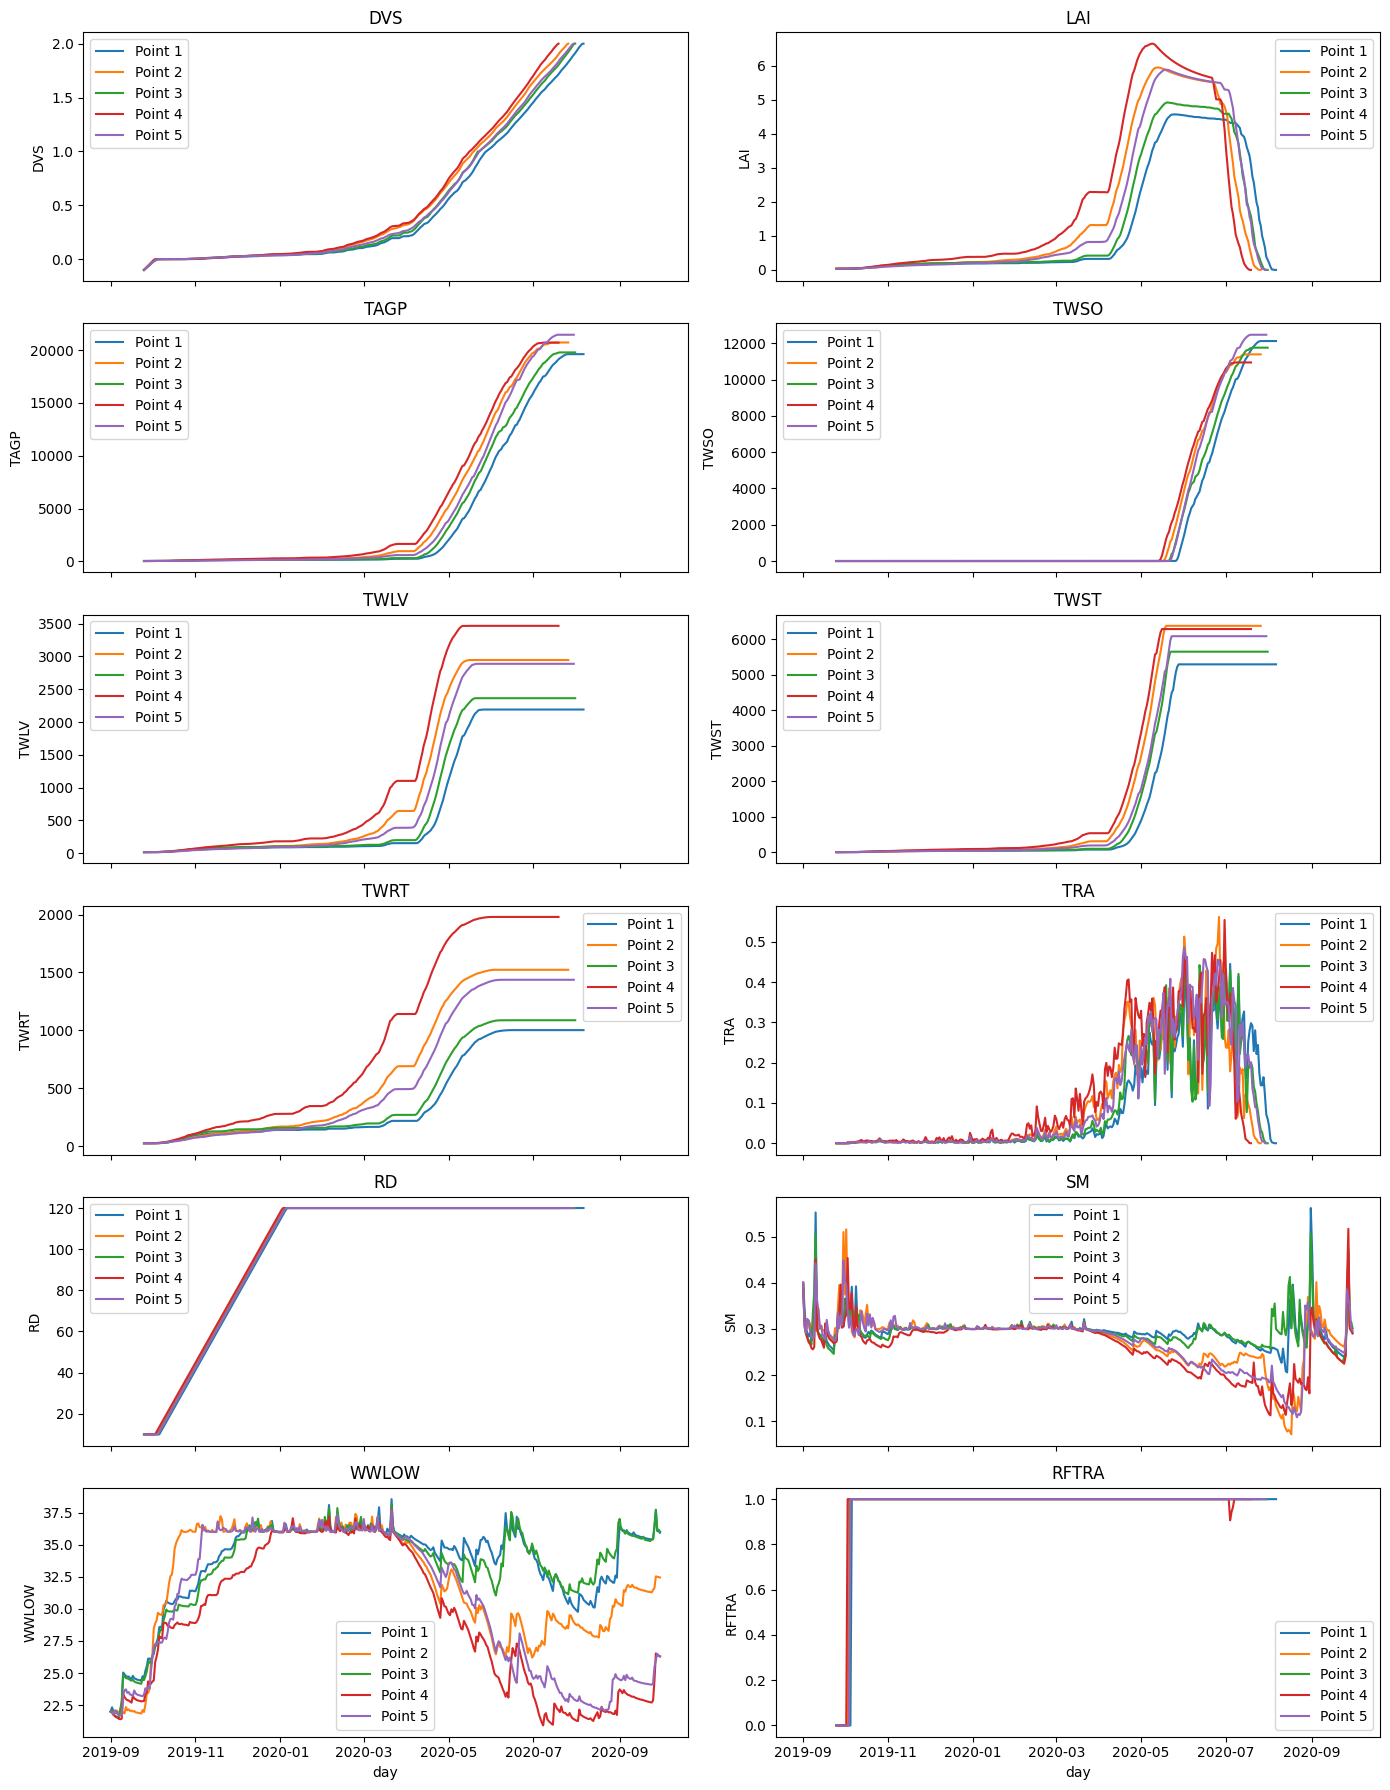

In [12]:
# Ensure 'day' is datetime
batch_results = results.copy()
batch_results['day'] = pd.to_datetime(batch_results['day'])

# Variables to plot (exclude metadata columns)
vars_to_plot = [
    col for col in batch_results.columns 
    if col not in ['point_id', 'latitude', 'longitude', 'day']
]

# Layout
cols = 2
rows = math.ceil(len(vars_to_plot) / cols)

# Colors for point_id groups
unique_points = batch_results['point_id'].unique()
palette = sns.color_palette("tab10", len(unique_points))
color_map = {pid: palette[i] for i, pid in enumerate(unique_points)}

fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows), sharex=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    for pid in unique_points:
        df_sub = batch_results[batch_results['point_id'] == pid]

        sns.lineplot(
            x=df_sub['day'],
            y=df_sub[var],
            ax=ax,
            label=f'Point {pid}',
            color=color_map[pid]
        )

    ax.set_title(var)
    ax.legend()

# Hide remaining empty subplots
for j in range(len(vars_to_plot), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()